In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you put all the files under MLSP24_HW2 folder in myDrive, then it should be 'MLSP24_HW2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'BERT'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
output_path = os.path.join(GOOGLE_DRIVE_PATH, 'output')
logs_path = os.path.join(GOOGLE_DRIVE_PATH, 'logs')
os.makedirs(output_path, exist_ok=True)
os.makedirs(logs_path, exist_ok=True)
print(os.listdir(GOOGLE_DRIVE_PATH))

['output', 'logs', 'model', 'bert.ipynb', 'bert2.ipynb']


In [4]:
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 38.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 8.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-n

In [5]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import TrainingArguments, Trainer
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

In [10]:
import pandas as pd
import re
import nltk
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

dataset = load_dataset("FinGPT/fingpt-sentiment-train")
train_data = dataset['train']
def process_data(data):
    processed_data = []
    output_to_label = {'negative': 0, 'positive': 1, 'neutral': 2}
    for item in data:
        if item['output'] in output_to_label:
            new_item = {
                'text': item['input'],  # Rename 'input' to 'text'
                'label': output_to_label[item['output']]  # Map 'output' to 'label'
            }
            processed_data.append(new_item)
    return processed_data
processed_data = process_data(train_data)
processed_data = processed_data[:20000]
def clean_input_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\$\w+', '', text)
    return text
for item in processed_data:
    item['text'] = clean_input_text(item['text'])
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    filtered_sentence = ' '.join(filtered_words)
    return filtered_sentence
#not used
#for item in processed_data:
    #item['text'] = remove_stop_words(item['text'])
def syn_replacement(text, n=3):
  words = word_tokenize(text)
  new_words = words.copy()
  random_word_list = list(set([word for word in words if word not in stopwords.words('english')]))
  random.shuffle(random_word_list)
  num_replaced = 0
  for random_word in random_word_list:
      synonyms = get_synonyms(random_word)
      if len(synonyms) >= 1:
          synonym = random.choice(list(synonyms))
          new_words = [synonym if word == random_word else word for word in new_words]
          num_replaced += 1
      if num_replaced >= n:
          break
  return ' '.join(new_words)

def get_synonyms(word):
    synonyms = set()
    for syn in nltk.corpus.wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    if word in synonyms:
        synonyms.remove(word)
    return synonyms
augmented_data = []
for item in processed_data:
    augmented_text = syn_replacement(item['text'])
    augmented_data.append({'text': augmented_text, 'label': item['label']})
processed_data.extend(augmented_data)
processed_data = Dataset.from_list(processed_data)
train_panda_df = processed_data.to_pandas()
train_df, test_df = train_test_split(train_panda_df, test_size=0.2, random_state=42)
train_df, validation_df = train_test_split(train_panda_df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
train_df = Dataset.from_pandas(train_df)
test_df = Dataset.from_pandas(test_df)
validation_df = Dataset.from_pandas(validation_df)

def tokenizer_function(examples):
    return tokenizer(examples['text'], max_length=128, padding="max_length", truncation=True)

train_token = train_df.map(tokenizer_function, batched=True)
validation_token = validation_df.map(tokenizer_function, batched=True)
test_token = test_df.map(tokenizer_function, batched=True)
batch_size = 32

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [ ]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
logging_steps = len(train_token) // batch_size
training_args = TrainingArguments(
    output_dir=output_path,
    learning_rate=3e-5,
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=300,
    weight_decay=0.02,
    logging_dir=logs_path,
    logging_steps=logging_steps,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model='accuracy'
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_token,
    eval_dataset=validation_token,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.136600,0.304689,0.923750,0.923835,0.926201,0.923750
2,0.110300,0.171799,0.952500,0.952504,0.952574,0.952500
3,0.035700,0.211048,0.954500,0.954497,0.954586,0.954500


TrainOutput(global_step=1500, training_loss=0.09420019022623698, metrics={'train_runtime': 1039.212, 'train_samples_per_second': 46.189, 'train_steps_per_second': 1.443, 'total_flos': 3157361012736000.0, 'train_loss': 0.09420019022623698, 'epoch': 3.0})

In [ ]:
model_path = os.path.join(GOOGLE_DRIVE_PATH, 'model')
os.makedirs(model_path, exist_ok=True)
model.save_pretrained(model_path)

In [ ]:
labels = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
def plot_confusion_matrix(y_preds, y_true, labels_dict):
  labels = [labels_dict[i] for i in range(len(labels_dict))]
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Normalized confusion matrix')
  return fig, ax

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>)

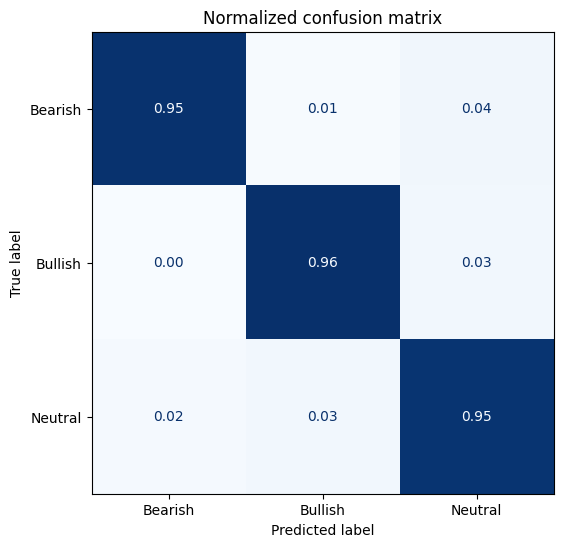

In [ ]:
preds_output = trainer.predict(validation_token)
y_preds = np.argmax(preds_output.predictions, axis=-1)
y_true = validation_token['label']
plot_confusion_matrix(y_preds, y_true, labels)

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>)

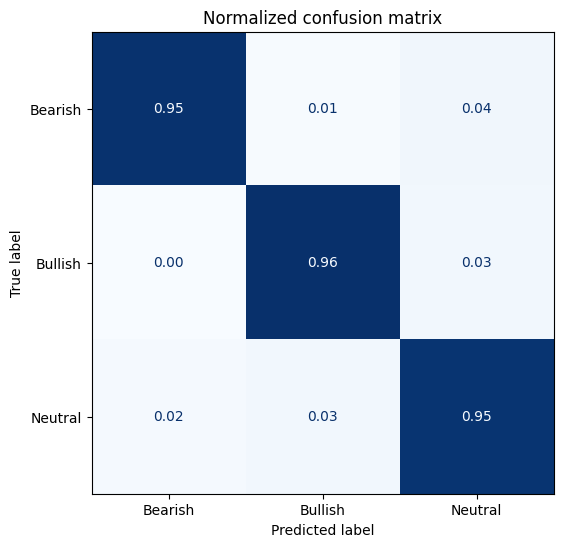

In [ ]:
preds_output = trainer.predict(test_token)
y_preds = np.argmax(preds_output.predictions, axis=-1)
y_true = test_token['label']
plot_confusion_matrix(y_preds, y_true, labels)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
report = classification_report(y_true, y_preds, target_names=list(labels.values()))
print(report)

              precision    recall  f1-score   support

     Bearish       0.95      0.95      0.95       762
     Bullish       0.95      0.96      0.96      1367
     Neutral       0.96      0.95      0.95      1871

    accuracy                           0.95      4000
   macro avg       0.95      0.96      0.95      4000
weighted avg       0.95      0.95      0.95      4000



In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
def tokenizer_function2(input_text):
    # Encode the input text
    encoded_input = tokenizer(input_text, return_tensors='pt', truncation=True, padding=True)
    return encoded_input

In [ ]:
def get_predictions(text):
    results = pipe(text)
    # Get the index of the highest probability class
    predicted_label = results[0]['label'].split('_')[-1]
    # Map labels to the dataset's label format (0, 1, 2)
    label_map = {'negative': 0, 'positive': 1, 'neutral': 2}
    return label_map[predicted_label]

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

In [ ]:
predicted_labels = [get_predictions(item['text']) for item in test_df]
actual_labels = [item['label'] for item in test_df]

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>)

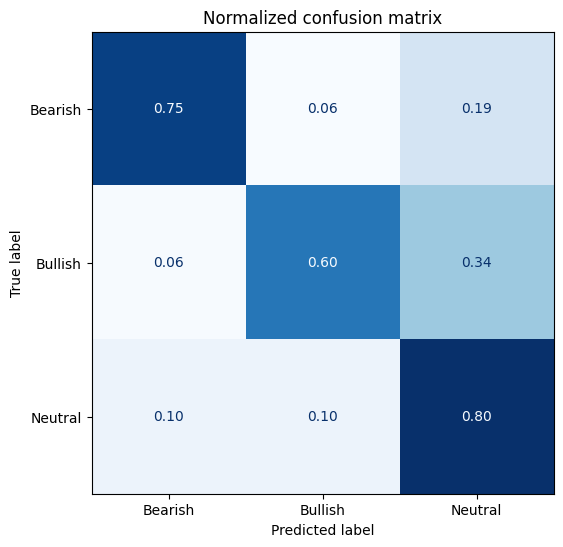

In [ ]:
plot_confusion_matrix(predicted_labels, actual_labels, labels)

In [ ]:
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
train_data = dataset['train']
validation_df = dataset['validation']
train_panda_df = train_data.to_pandas()
train_df, test_df = train_test_split(train_panda_df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df = Dataset.from_pandas(train_df)
test_df = Dataset.from_pandas(test_df)

def tokenizer_function(examples):
    return tokenizer(examples['text'], max_length=128, padding="max_length", truncation=True)

train_token = train_df.map(tokenizer_function, batched=True)
validation_token = validation_df.map(tokenizer_function, batched=True)
test_token = test_df.map(tokenizer_function, batched=True)
batch_size = 32

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>)

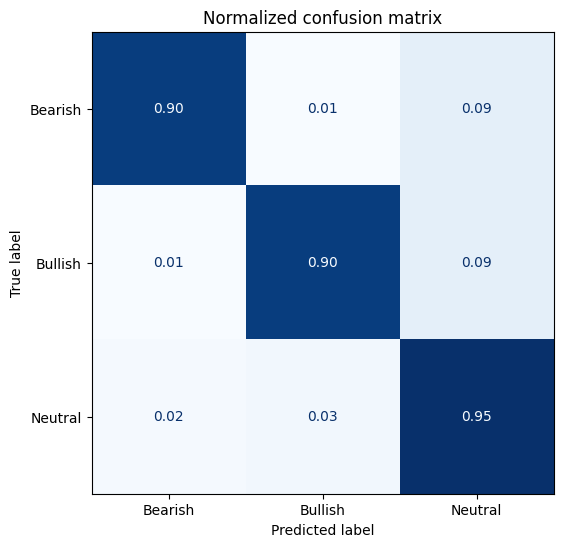

In [ ]:
preds_output = trainer.predict(test_token)
y_preds = np.argmax(preds_output.predictions, axis=-1)
y_true = test_token['label']
plot_confusion_matrix(y_preds, y_true, labels)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
report = classification_report(y_true, y_preds, target_names=list(labels.values()))
print(report)

              precision    recall  f1-score   support

     Bearish       0.94      0.90      0.92       762
     Bullish       0.95      0.90      0.92      1367
     Neutral       0.90      0.95      0.92      1871

    accuracy                           0.92      4000
   macro avg       0.93      0.92      0.92      4000
weighted avg       0.93      0.92      0.92      4000



(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>)

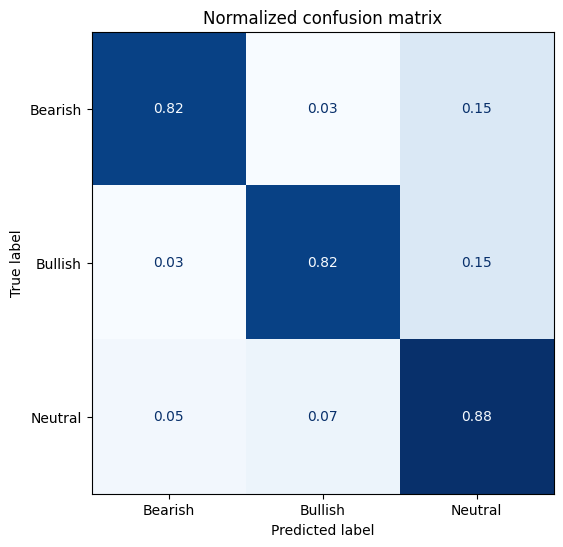

In [ ]:
preds_output = trainer.predict(validation_token)
y_preds = np.argmax(preds_output.predictions, axis=-1)
y_true = validation_token['label']
plot_confusion_matrix(y_preds, y_true, labels)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
report = classification_report(y_true, y_preds, target_names=list(labels.values()))
print(report)

              precision    recall  f1-score   support

     Bearish       0.76      0.82      0.79       347
     Bullish       0.76      0.82      0.79       475
     Neutral       0.92      0.88      0.90      1566

    accuracy                           0.86      2388
   macro avg       0.81      0.84      0.82      2388
weighted avg       0.86      0.86      0.86      2388

